In [96]:
import sys
sys.path.append('../code')

from sbi_utils import set_params
from generate_simulations import set_params

import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

from hnn_core.batch_simulate import BatchSimulate
from hnn_core import jones_2009_model, pick_connection, calcium_model, read_params, read_network_configuration, read_dipole
from hnn_core.network_models import add_erp_drives_to_jones_model
from sbi.inference import NPE
from sbi import utils

import pandas as pd
import seaborn as sns
import torch
import os
from scipy.stats import norm
from scipy.interpolate import CubicSpline
import pickle


# The number of cores may need modifying depending on your current machine.
n_jobs = 50

In [2]:
save_path = '/oscar/data/sjones/ntolley/hnn_jove/jones_2009_jove'


rng = np.random.default_rng(seed=123)

num_sims = 10000
tstop = 250
dt = 0.025

min_val, max_val = -1, 1
theta_train_dict = {
    'ff_sync_scale': rng.uniform(0, 5, num_sims),
    'km_scale': rng.uniform(min_val, max_val, num_sims),
    'inh_gain_scale': rng.uniform(min_val, max_val, num_sims),
    'fb_gain_scale': [0, 0, 0, 0, 1],
}

theta_cond_dict = {
    'ff_sync_scale':  [1, 3, 1, 1, 1],
    'km_scale':       [0, 0, 1, 0, 0],
    'inh_gain_scale': [0, 0, 0, 1, 0],
    'fb_gain_scale':  [0, 0, 0, 0, 1],
}

# Initialize the network model and run the batch simulation.
# l_contra_params = read_params('../data/L_Contra.param')
# net_base = calcium_model(params=l_contra_params, add_drives_from_params=False)

# net = jones_2009_model()
net_base = read_network_configuration('../data/opt_baseline_config_correlation_best.json')




In [3]:

    
# Class for quickly generating conditioning observations with no saving
batch_simulation_cond = BatchSimulate(net=net_base,
                                      set_params=set_params,
                                      tstop=tstop,
                                      dt=dt,)

cond_results = batch_simulation_cond.run(theta_cond_dict,
                                          n_jobs=n_jobs,
                                          combinations=False,
                                          backend='loky')

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building th

In [4]:
scale_factor = 1000
smooth_window = 40
downsample = 20

# Load batch simulations used for SBI training
dpl_list, theta_train = list(), list()
for fname in os.listdir(save_path):
    if '.npz' in fname:
        res = np.load(f'{save_path}/{fname}', allow_pickle=True)
        for dpl in res['dpl']:
            dpl_list.append(dpl[0].copy().smooth(smooth_window).scale(scale_factor).data['agg'][::downsample])

        for param_dict in res['param_values']:
            theta_train.append(np.array(list(param_dict.values())))

dpl_list = np.array(dpl_list)
theta_train_all = np.array(theta_train)



In [5]:
mask = np.mean(dpl_list[:, :100], axis=1) > -1000
print(np.sum(mask) / dpl_list.shape[0])

1.0


Text(0.5, 1.0, 'Variance Explained')

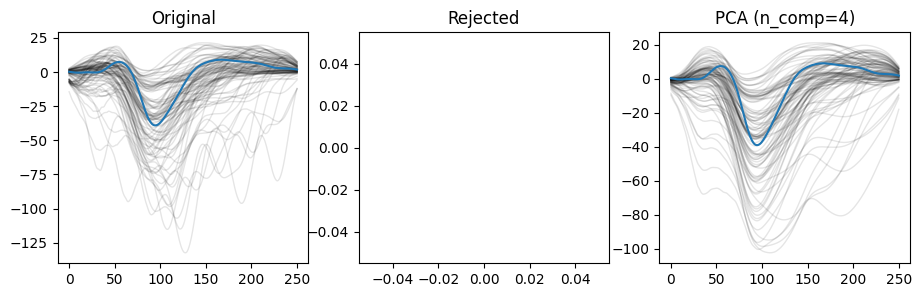

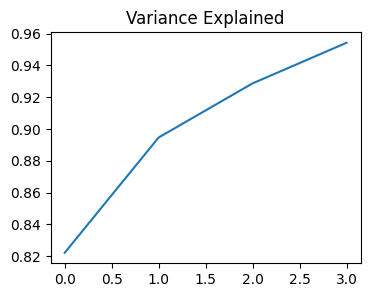

In [6]:
times = np.linspace(0, tstop, dpl_list.shape[1])

# Load experimental biomarker
dipole_experimental = read_dipole('../data/L_Contra.txt')
baseline_cs = CubicSpline(dipole_experimental.times, dipole_experimental.data['agg'])

baseline_dpl = baseline_cs(times)

# Fit PCA to training simulations
n_components = 4
pca = PCA(n_components=n_components)
x_train = pca.fit_transform(dpl_list[mask])
theta_train = theta_train_all[mask]
dpl_transform = pca.inverse_transform(x_train)


plt.figure(figsize=(11, 3))
plt.subplot(1,3,1)
_ = plt.plot(times, dpl_list[mask][:100, :].T, color='k', alpha=0.1, linewidth=1)
plt.plot(times, baseline_dpl, color='C0')
plt.title('Original')
plt.subplot(1,3,2)
_ = plt.plot(times, dpl_list[~mask][:100, :].T, color='k', alpha=0.1, linewidth=1)
plt.title('Rejected')
plt.subplot(1,3,3)
_ = plt.plot(times, dpl_transform[:100, :].T, color='k', alpha=0.1, linewidth=1)
plt.plot(times, baseline_dpl, color='C0')
plt.title(f'PCA (n_comp={n_components})')

plt.figure(figsize=(4,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Variance Explained')



In [80]:
# prior_min = [0, -1, -1, -1]
# prior_max = [5, 1, 1, 1]
# prior = utils.torchutils.BoxUniform(
#     low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
# )

# # Create inference object. Here, NPE is used.
# inference = NPE(prior=prior)
# inference = inference.append_simulations(torch.tensor(theta_train).float(), torch.tensor(x_train).float())

# # train the density estimator and build the posterior
# density_estimator = inference.train()
# posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 367 epochs.

In [98]:
# Save posterior oject
# with open("../data/sbi_posterior.pkl", "wb") as handle:
#     pickle.dump(posterior, handle)

# Load posterior object
with open("../data/sbi_posterior.pkl", "rb") as handle:
    posterior = pickle.load(handle)


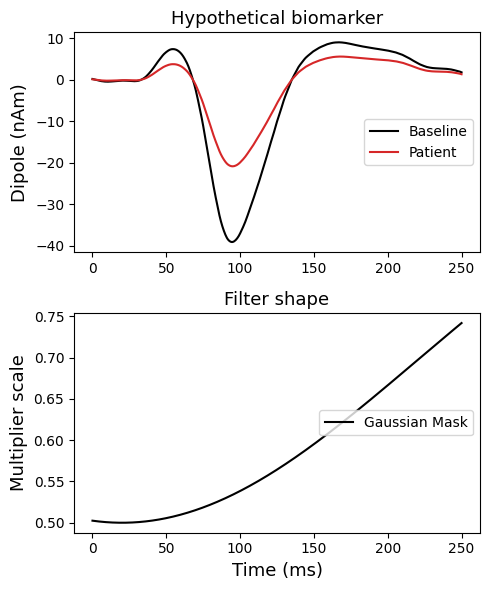

In [81]:
labelsize = 13
ticksize = 10
titlesize = 13



# THIS IS THE DEFAULT
# biomarker_scale = -0.1
# gauss = norm.pdf(times, loc=10, scale=40)

biomarker_scale = 0.5
gauss = norm.pdf(times, loc=20, scale=200)

# biomarker_scale = 2
# gauss = norm.pdf(times, loc=120, scale=30)

gauss = (gauss / np.max(gauss)) * (biomarker_scale - 1)
gauss += 1
biomarker_dpl = baseline_dpl * gauss


plt.figure(figsize=(5,6))
plt.subplot(2,1,1)
plt.plot(times, baseline_dpl, label='Baseline', color='k')
plt.plot(times, biomarker_dpl, label='Patient', color='C3')
plt.legend(loc='center right')
plt.title('Hypothetical biomarker', fontsize=titlesize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)


plt.subplot(2,1,2)
plt.plot(times, gauss, color='k', label='Gaussian Mask')
plt.legend(loc='center right')
plt.xlabel('Time (ms)', fontsize=labelsize)
plt.ylabel('Multiplier scale', fontsize=labelsize)

plt.title('Filter shape', fontsize=titlesize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.tight_layout()

In [82]:
x_cond = pca.transform(np.stack([baseline_dpl, biomarker_dpl]))

num_samples = 1000
label_names = ['Healthy', 'Patient']
sample_list, label_list = list(), list()

for cond_idx in range(x_cond.shape[0]):
    samples = posterior.sample((num_samples,), x=x_cond[cond_idx,:])
    sample_list.append(samples.numpy())

    label_list.extend(np.repeat(label_names[cond_idx], num_samples))

sample_list = np.concatenate(sample_list)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [83]:
# param_labels = ['FF gain ($\\bar{g}$)', 'Km channel ($\\bar{g}$)', 'GABA$\\rightarrow$I cell ($\\bar{g}$)']
param_labels = [
     'Th$\\rightarrow$Ctx synchrony',
    'Dendritic Km',
    'GABAb conductance',
    'Ctx$\\rightarrow$Ctx strength']
sample_list = np.array(sample_list)
df = pd.DataFrame(sample_list)
df.columns = param_labels
df['cond'] = label_list
df = df[df['cond'] != 'base']

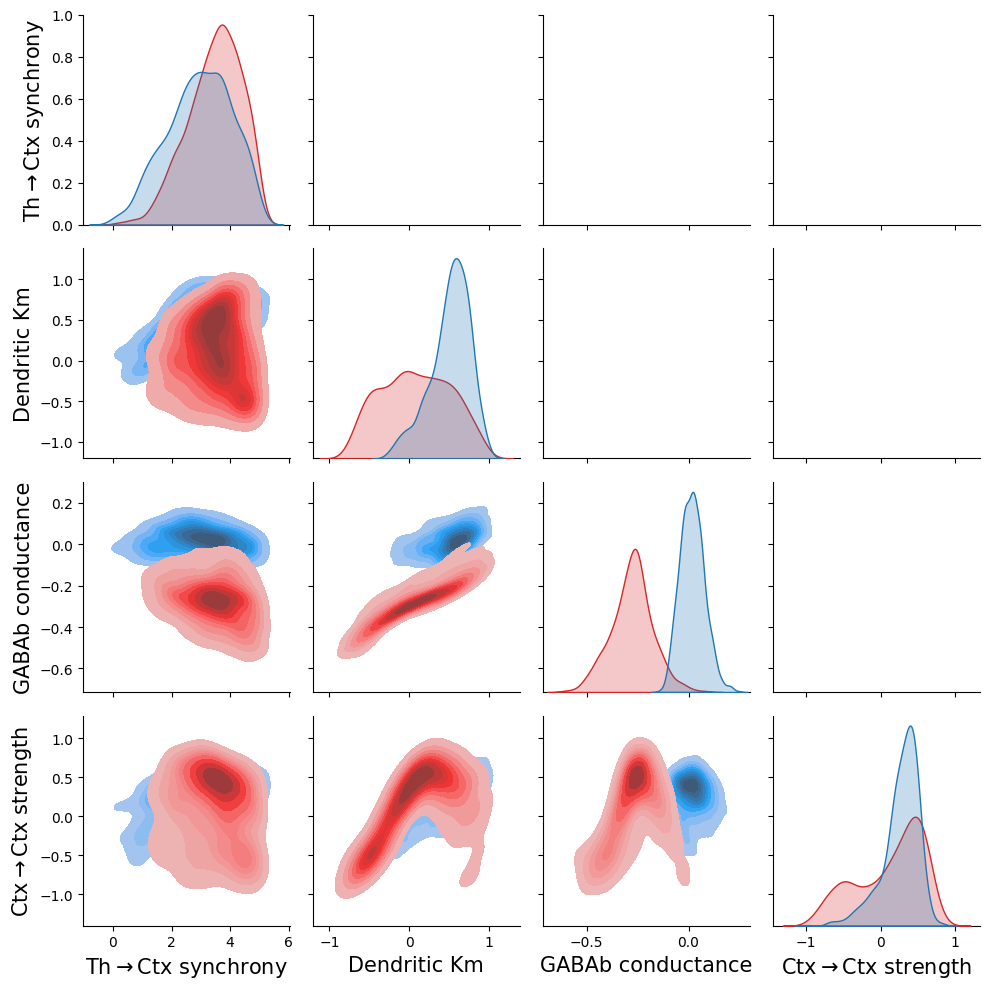

In [84]:
labelsize = 15

color_palette = ['C0', 'C3']

g = sns.PairGrid(df, diag_sharey=False, corner=False, hue='cond', palette=color_palette, height=2.5)
g.map_lower(sns.kdeplot, fill=True, common_norm=False)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(4):
    # y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])
    # g.axes[idx, idx].set_xlim(-0.5, 1.5)
    # g.axes[idx, idx].set_ylim(-0.5, 1.5)

    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[3,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

            
    # g.axes[idx, 0].set_yticks(tick_dict[f'p{idx+4}_tick_pos'])
    # g.axes[3, idx].set_xticks(tick_dict[f'p{idx+4}_tick_pos'])
    # g.axes[idx, 0].set_yticklabels(tick_dict[f'p{idx+4}_tick_labels'], fontsize=ticksize, rotation=0)
    # g.axes[3, idx].set_xticklabels(tick_dict[f'p{idx+4}_tick_labels'], fontsize=ticksize, rotation=0)
plt.tight_layout()

plt.savefig('../figures/drug_moa_sbi_posterior.svg')

In [85]:
n_ppc_sims = 10
baseline_ppc_theta = sample_list[:n_ppc_sims, :]
biomarker_ppc_theta = sample_list[num_samples:(num_samples + n_ppc_sims), :]
ppc_theta = np.concatenate([baseline_ppc_theta, biomarker_ppc_theta])
ppc_labels = np.repeat(['Basline', 'Patient'], n_ppc_sims)

theta_ppc_dict = {name: ppc_theta[:, idx] for idx, name in enumerate(theta_cond_dict.keys())}

In [86]:
# Class for quickly generating conditioning observations with no saving
batch_simulation_ppc = BatchSimulate(net=net_base,
                                      set_params=set_params,
                                      tstop=tstop,
                                      dt=dt,)

ppc_results = batch_simulation_ppc.run(theta_ppc_dict,
                                          n_jobs=n_jobs,
                                          combinations=False,
                                          backend='loky')

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2

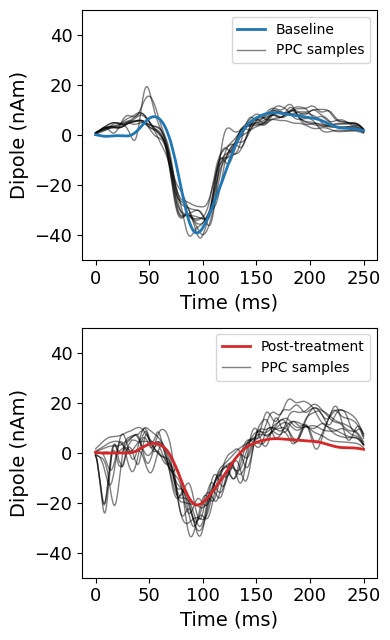

In [92]:
downsample = 20
ppc_dpl = [res['dpl'][0].copy().smooth(20).scale(scale_factor).data['agg'][::downsample] for res in ppc_results['simulated_data'][0]]
baseline_ppc_dpl = np.stack(ppc_dpl[:n_ppc_sims])
biomarker_ppc_dpl = np.stack(ppc_dpl[n_ppc_sims:])

plt.figure(figsize=(4, 6.5))
plt.subplot(2,1,1)
plt.plot(times, baseline_ppc_dpl.T, color='k', alpha=0.5, linewidth=1)
plt.plot(times, baseline_dpl, label='Baseline', color='C0', linewidth=2)
plt.plot([0,0], [1000,100], color='k', alpha=0.5, linewidth=1, label='PPC samples')


ymin = -50
ymax = 50

plt.legend(loc='upper right')
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)
plt.xlabel('Time (ms)', fontsize=labelsize)

plt.ylim(ymin, ymax)


plt.subplot(2,1,2)
plt.plot(times, biomarker_ppc_dpl.T, color='k', alpha=0.5, linewidth=1)
plt.plot(times, biomarker_dpl, label='Post-treatment', color='C3', linewidth=2)
plt.plot([0,0], [1000,100], color='k', alpha=0.5, linewidth=1, label='PPC samples')


plt.legend(loc='upper right')
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)
plt.ylim(ymin, ymax)
plt.xlabel('Time (ms)', fontsize=labelsize)


plt.tight_layout()

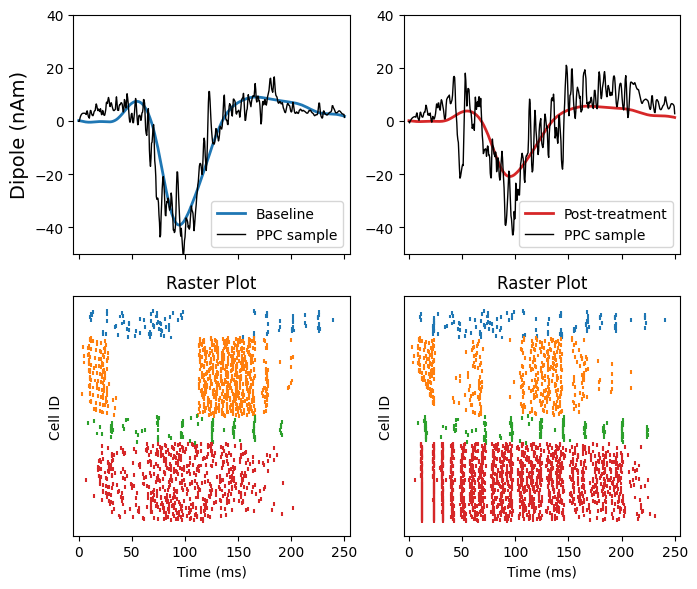

In [91]:
ppc_sample_idx = 2

ppc_dpl = [res['dpl'][0].copy().smooth(1).scale(scale_factor).data['agg'][::downsample] for res in ppc_results['simulated_data'][0]]
ppc_net = [res['net'] for res in ppc_results['simulated_data'][0]]

baseline_ppc_dpl = np.stack(ppc_dpl[:n_ppc_sims])
baseline_ppc_net = np.stack(ppc_net[:n_ppc_sims])

biomarker_ppc_dpl = np.stack(ppc_dpl[n_ppc_sims:])
biomarker_ppc_net = np.stack(ppc_net[n_ppc_sims:])
ticksize = 13
labelsize = 14
titlesize = 16

times = np.linspace(0, tstop, len(baseline_dpl))


fig, axes = plt.subplots(2, 2, figsize=(7,6), sharex=True)
axes[0, 0].plot(times, baseline_dpl, linewidth=2, color=f'C0', label='Baseline')
axes[0, 0].plot(times, baseline_ppc_dpl[ppc_sample_idx], linewidth=1, color='k', label='PPC sample')
axes[0, 0].set_ylim(ymin, ymax)
axes[0, 0].set_ylabel('Dipole (nAm)', fontsize=labelsize)
axes[0,0].legend(loc='lower right')
baseline_ppc_net[0].cell_response.plot_spikes_raster(ax=axes[1,0], show=False, show_legend=False)
axes[0, 0].set_xlim(-5, 255)


axes[0, 1].plot(times, biomarker_dpl, linewidth=2, color=f'C3', label='Post-treatment')
axes[0, 1].plot(times, biomarker_ppc_dpl[ppc_sample_idx], linewidth=1, color='k', label='PPC sample')
axes[0, 1].set_ylim(ymin, ymax)
axes[0, 0].set_ylabel('Dipole (nAm)', fontsize=labelsize)
axes[0,1].legend(loc='lower right')
biomarker_ppc_net[0].cell_response.plot_spikes_raster(ax=axes[1,1], show=False, show_legend=False)
axes[0, 1].set_xlim(-5, 255)




plt.tight_layout()
